In [1]:
import penaltyblog as pb
import pandas as pd
import numpy as np
import datetime as dt
import dataframe_image as dfi
from random import choices
import json
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

In [ ]:
import sys
sys.path.append('../')
from src.utils import (simulate_match, analyse_match, table_bonus_check, calculate_manager_points, simulate_season_fpl)

# Data

In [3]:
#fb = pb.scrapers.FootballData("ENG Premier League", "2023-2024")
#df_list = [fb.get_fixtures()]
#fb = pb.scrapers.FootballData("ENG Premier League", "2024-2025")
#df_list.append(fb.get_fixtures())

#df = pd.concat(df_list)
#display(df)

In [4]:
matches24_25 = pd.read_html('https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures')[0]
matches23_24 = pd.read_html('https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures')[0]
fixtures_fbref = pd.concat([matches23_24, matches24_25], ignore_index=True)
fixtures_fbref['Date'] = pd.to_datetime(fixtures_fbref['Date'])

df = fixtures_fbref[fixtures_fbref['Score'].notnull()]
df = df.reset_index()

df['goals_home'] = df['Score'].apply(lambda x: x.split('–')[0])
df['goals_away'] = df['Score'].apply(lambda x: x.split('–')[1])

df.rename(columns={'Home': 'team_home', 'Away': 'team_away', 'Date': 'date'}, inplace=True)

df

,index,Wk,Day,date,Time,team_home,xG,Score,xG.1,team_away,Attendance,Venue,Referee,Match Report,Notes,goals_home,goals_away
0,0,1.0,Fri,2023-08-11,20:00,Burnley,0.3,0–3,1.9,Manchester City,21572.0,Turf Moor,Craig Pawson,Match Report,NaN,0,3
1,1,1.0,Sat,2023-08-12,12:30,Arsenal,0.8,2–1,1.2,Nott'ham Forest,59984.0,Emirates Stadium,Michael Oliver,Match Report,NaN,2,1
2,2,1.0,Sat,2023-08-12,15:00,Everton,2.7,0–1,1.5,Fulham,39940.0,Goodison Park,Stuart Attwell,Match Report,NaN,0,1
3,3,1.0,Sat,2023-08-12,15:00,Brighton,4.0,4–1,1.5,Luton Town,31872.0,The American Express Community Stadium,David Coote,Match Report,NaN,4,1
4,4,1.0,Sat,2023-08-12,15:00,Sheffield Utd,0.5,0–1,1.9,Crystal Palace,31194.0,Bramall Lane,John Brooks,Match Report,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,754,31.0,Sat,2025-04-05,12:30,Everton,1.0,1–1,1.8,Arsenal,39316.0,Goodison Park,Darren England,Match Report,NaN,1,1
680,755,31.0,Sat,2025-04-05,15:00,Crystal Palace,0.6,2–1,0.9,Brighton,24564.0,Selhurst Park,Anthony Taylor,Match Report,NaN,2,1
681,756,31.0,Sat,2025-04-05,15:00,Ipswich Town,0.8,1–2,2.6,Wolves,29549.0,Portman Road Stadium,Peter Bankes,Match Report,NaN,1,2
682,757,31.0,Sat,2025-04-05,15:00,West Ham,0.6,2–2,2.1,Bournemouth,NaN,London Stadium,Tim Robinson,Match Report,NaN,2,2


In [5]:
current_date = dt.datetime.today()
df['days_since'] = df['date'].apply(lambda x: (current_date-x).days)
df = df[df.days_since <= 365].copy()
df

,index,Wk,Day,date,Time,team_home,xG,Score,xG.1,team_away,Attendance,Venue,Referee,Match Report,Notes,goals_home,goals_away,days_since
303,337,32.0,Sat,2024-04-06,12:30,Crystal Palace,1.1,2–4,1.9,Manchester City,25132.0,Selhurst Park,Paul Tierney,Match Report,NaN,2,4,365
304,338,32.0,Sat,2024-04-06,15:00,Luton Town,1.5,2–1,0.4,Bournemouth,11797.0,Kenilworth Road Stadium,Andy Madley,Match Report,NaN,2,1,365
305,339,32.0,Sat,2024-04-06,15:00,Everton,0.9,1–0,0.5,Burnley,39125.0,Goodison Park,Michael Oliver,Match Report,NaN,1,0,365
306,340,32.0,Sat,2024-04-06,15:00,Wolves,1.5,1–2,1.2,West Ham,31504.0,Molineux Stadium,Tony Harrington,Match Report,NaN,1,2,365
307,341,32.0,Sat,2024-04-06,15:00,Aston Villa,1.5,3–3,1.5,Brentford,42118.0,Villa Park,Michael Salisbury,Match Report,NaN,3,3,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,754,31.0,Sat,2025-04-05,12:30,Everton,1.0,1–1,1.8,Arsenal,39316.0,Goodison Park,Darren England,Match Report,NaN,1,1,1
680,755,31.0,Sat,2025-04-05,15:00,Crystal Palace,0.6,2–1,0.9,Brighton,24564.0,Selhurst Park,Anthony Taylor,Match Report,NaN,2,1,1
681,756,31.0,Sat,2025-04-05,15:00,Ipswich Town,0.8,1–2,2.6,Wolves,29549.0,Portman Road Stadium,Peter Bankes,Match Report,NaN,1,2,1
682,757,31.0,Sat,2025-04-05,15:00,West Ham,0.6,2–2,2.1,Bournemouth,NaN,London Stadium,Tim Robinson,Match Report,NaN,2,2,1


In [6]:
league_table = pd.read_html('https://fbref.com/en/comps/9/Premier-League-Stats')[0]
#league_table['Squad'] = league_table['Squad'].replace(team_name_dict)
league_table

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Last 5,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Liverpool,30,22,7,1,70,27,43,73,2.43,66.4,26.0,40.4,1.35,D W W W W,60311,Mohamed Salah - 27,Alisson,NaN
1,2,Arsenal,31,17,11,3,56,26,30,62,2.00,48.5,26.8,21.7,0.70,D D W W D,60276,Kai Havertz - 9,David Raya,NaN
2,3,Nott'ham Forest,31,17,6,8,51,37,14,57,1.84,38.2,38.1,0.1,0.00,D W W W L,30091,Chris Wood - 18,Matz Sels,NaN
3,4,Chelsea,30,15,7,8,54,37,17,52,1.73,56.9,40.3,16.6,0.55,L W W L W,39610,Cole Palmer - 14,Robert Sánchez,NaN
4,5,Manchester City,30,15,6,9,57,40,17,51,1.70,53.6,39.5,14.1,0.47,L W L D W,52819,Erling Haaland - 21,Ederson,NaN
5,6,Aston Villa,31,14,9,8,46,46,0,51,1.65,44.9,42.1,2.8,0.09,W L W W W,42008,Ollie Watkins - 13,Emiliano Martínez,NaN
6,7,Newcastle Utd,29,15,5,9,49,39,10,50,1.72,47.5,36.9,10.6,0.37,L W L W W,52177,Alexander Isak - 20,Nick Pope,NaN
7,8,Brighton,31,12,11,8,49,47,2,47,1.52,45.5,42.9,2.6,0.08,W W D L L,31888,"Danny Welbeck, João Pedro - 8",Bart Verbruggen,NaN
8,9,Bournemouth,31,12,9,10,51,40,11,45,1.45,56.9,40.6,16.4,0.53,L D L L D,11209,Justin Kluivert - 12,Kepa Arrizabalaga,NaN
9,10,Fulham,30,12,9,9,44,40,4,45,1.50,40.8,35.2,5.6,0.19,L W L W L,26592,Raúl Jiménez - 10,Bernd Leno,NaN


In [7]:
teams = np.sort(league_table['Squad'].unique())
teams

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Ipswich Town',
       'Leicester City', 'Liverpool', 'Manchester City', 'Manchester Utd',
       'Newcastle Utd', "Nott'ham Forest", 'Southampton', 'Tottenham',
       'West Ham', 'Wolves'], dtype=object)

In [8]:
fpl_fixtures_data = json.loads(requests.get('https://fantasy.premierleague.com/api/fixtures/').text)
fpl_fixtures = pd.DataFrame(fpl_fixtures_data)
fpl_fixtures['home_team'] = [teams[i] for i in fpl_fixtures['team_h']-1]
fpl_fixtures['away_team'] = [teams[i] for i in fpl_fixtures['team_a']-1]
#fpl_fixtures
display(fpl_fixtures.shape)

(380, 19)

In [9]:
fixtures = fpl_fixtures[fpl_fixtures['team_h_score'].isnull()].reset_index(drop=True)
#fixtures
display(fixtures.shape)

(76, 19)

# Model

In [10]:
xi = 0.001
weights = pb.models.dixon_coles_weights(df["date"], xi)

clf = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"], weights
)
clf.fit()

Module: Penaltyblog

Class: FootballProbabilityGrid

Home Goal Expectation: [2.04344706]
Away Goal Expectation: [1.49499157]

Home Win: 0.5041559912294908
Draw: 0.21321049754453392
Away Win: 0.2826335060150147

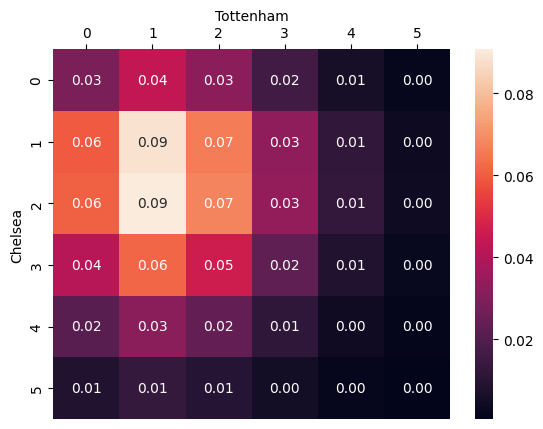

In [11]:
homeTeam = "Chelsea"
awayTeam = "Tottenham"
analyse_match(clf, homeTeam, awayTeam)

# Team ratings

In [12]:
#teams = "Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich Town,Leicester City,Liverpool,Manchester City,Manchester Utd,Newcastle Utd,Nott'ham Forest,Southampton,Tottenham,West Ham,Wolves" 
#teams = teams.split(',')

In [13]:
# Extract attack and defense parameters
params = clf.get_params()
attack_params = {k: v for k, v in params.items() if k.startswith('attack_')}
defense_params = {k: v for k, v in params.items() if k.startswith('defence_')}

# Compute median values
median_attack = np.median(list(attack_params.values()))
median_defense = np.median(list(defense_params.values()))

# Find teams with median values
median_attack_team = [team.split('attack_')[1] for team, value in attack_params.items() if value == median_attack]
median_defense_team = [team.split('defence_')[1] for team, value in defense_params.items() if value == median_defense]

print(f"Median attack value: {median_attack}, Team(s): {median_attack_team}")
print(f"Median defense value: {median_defense}, Team(s): {median_defense_team}")

Median attack value: 1.0308324678911738, Team(s): ['Brighton']
Median defense value: -0.6702942291357071, Team(s): ['Aston Villa']


In [ ]:
ratings = []
for team in teams:
    team_attack_rating_home =  clf.predict(team, median_defense_team[0]).home_goal_expectation
    team_attack_rating_away = clf.predict(median_defense_team[0], team).away_goal_expectation
    team_attack_rating = np.mean((team_attack_rating_home, team_attack_rating_away))
    
    team_defense_rating_home = clf.predict(team, median_attack_team[0]).away_goal_expectation
    team_defense_rating_away = clf.predict(median_attack_team[0], team).home_goal_expectation
    team_defense_rating = np.mean((team_defense_rating_home, team_defense_rating_away))
    
    team_goal_difference_rating = team_attack_rating - team_defense_rating
    ratings.append((team, team_attack_rating, team_defense_rating, team_goal_difference_rating))

ratings_df = pd.DataFrame(ratings, columns=['team', 'attack_rating', 'defense_rating', 'goal_difference_rating']).sort_values(by='goal_difference_rating', ascending=False).reset_index(drop=True)
ratings_df.index += 1

dfi.export(ratings_df, "../ratings.png", table_conversion='matplotlib',)

display(ratings_df)

,team,attack_rating,defense_rating,goal_difference_rating
1,Liverpool,2.314850,1.032367,1.282483
2,Arsenal,1.933621,0.778781,1.154840
3,Manchester City,2.202715,1.159236,1.043479
4,Chelsea,1.962563,1.254029,0.708534
5,Newcastle Utd,1.880574,1.292263,0.588311
6,Crystal Palace,1.592937,1.122514,0.470423
7,Nott'ham Forest,1.655050,1.270121,0.384929
8,Tottenham,1.850183,1.495448,0.354735
9,Bournemouth,1.584841,1.318897,0.265943
10,Brentford,1.737310,1.495936,0.241374


# Simulate season

In [15]:
#team_name_dict = {"Nott'ham Forest": "Nott'm Forest",
#                  'Manchester City': 'Man City',
#                  'Manchester Utd': 'Man United',
#                  'Newcastle Utd': 'Newcastle',
#                  'Ipswich Town': 'Ipswich',
#                  'Leicester City': 'Leicester',
#                  }

In [ ]:
nr_simulations = 1000
simulation_results = []
manager_results = []
final_gameweek = 38
for i in tqdm(range(nr_simulations), desc='Simulating...'):
    simulated_table = league_table[['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].copy()
    simulated_table, manager_xp = simulate_season_fpl(simulated_table, fixtures, clf, final_gameweek)
    simulated_table['simulation_nr'] = i
    simulation_results.append(simulated_table)

    manager_df = pd.DataFrame(manager_xp, columns=['gameweek', 'team', 'expected_points'])
    manager_df['simulation_nr'] = i
    manager_results.append(manager_df)

print('Done!')

simulation_results_df = pd.concat(simulation_results).reset_index(drop=True)
manager_results_df = pd.concat(manager_results).reset_index(drop=True)

Simulating...: 100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]

Done!


In [ ]:
result_matrix = (
    simulation_results_df.groupby(['Squad', 'Rk'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 21), fill_value=0)  # Ensure columns go from 1 to 20
)

# normalize to percentage
result_matrix = 100 * (result_matrix / nr_simulations)

In [ ]:
# Reorder the matrix based on average final league position
sorted_teams = simulation_results_df.groupby(['Squad'])['Rk'].mean().sort_values().index
sorted_matrix = result_matrix.loc[sorted_teams]

# Plot the reordered heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_matrix, annot=True, cmap="Blues", linewidths=0.5, cbar_kws={'label': 'Probability'})

timestamp = dt.datetime.now().strftime("%d.%m.%Y")
if final_gameweek == 38:
    plt.title(f"Distribution of Final League Positions \n(forecast on {timestamp} with a Dixon-Coles model)")
else:
    plt.title(f"Distribution of League Positions after gameweek {final_gameweek} \n(forecast on {timestamp} with a Dixon-Coles model)")
plt.xlabel("Final League Position")
plt.ylabel("Team")

plt.savefig('league_distribution.png')

plt.show()

# FPL Assistant Manager analysis

In [ ]:
weekly_scores = (manager_results_df.groupby(['gameweek', 'team']).sum() / nr_simulations).reset_index()

In [ ]:
# fill weeks with no game with 0 manager points
# Get all unique gameweeks and teams
all_gameweeks = range(int(weekly_scores['gameweek'].min()), int(weekly_scores['gameweek'].max()) + 1)
all_teams = weekly_scores['team'].unique()

# Create a MultiIndex for all possible gameweek-team combinations
idx = pd.MultiIndex.from_product([all_gameweeks, all_teams], names=['gameweek', 'team'])

# Reindex the DataFrame to include missing gameweeks for each team
weekly_scores = weekly_scores.set_index(['gameweek', 'team']).reindex(idx, fill_value=0).reset_index()

weekly_scores[["rolling_expected_points"]] = weekly_scores.groupby("team").rolling(3, on='gameweek').sum().reset_index(level=0, drop=True)[["expected_points"]]
#weekly_scores[["rolling_quantile_10", "rolling_quantile_30", "rolling_expected_points", "rolling_quantile_70", "rolling_quantile_90"]] = weekly_scores.groupby("team").rolling(3, on='gameweek').sum().reset_index(level=0, drop=True)[["quantile_10", "quantile_30", "expected_points", "quantile_70", "quantile_90"]]

weekly_scores

In [ ]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['expected_points'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"Expected Points per Game Week - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"Expected Points per Game Week - {default_team}",
    xaxis_title="Game Week",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()

In [ ]:
# Get unique teams
teams = np.sort(weekly_scores['team'].unique())
default_team = teams[0]  # Default highlighted team

# Create figure
fig = go.Figure()

for team in teams:
    fig.add_trace(go.Scatter(
        x=weekly_scores[weekly_scores['team'] == team]['gameweek'],
        y=weekly_scores[weekly_scores['team'] == team]['rolling_expected_points'],
        mode='lines+markers',
        name=team,
        line=dict(color='blue' if team == default_team else 'gray'),
        opacity=1 if team == default_team else 0.3,
        visible=True
    ))

# Create dropdown menu
dropdown_buttons = []
for selected_team in teams:
    button = {
        "label": selected_team,
        "method": "update",
        "args": [
            {
                "opacity": [1 if team == selected_team else 0.3 for team in teams],
                "line": [dict(color="blue" if team == selected_team else "gray") for team in teams],
            },
            {"title": f"3-week Rolling Sum of Expected Points - {selected_team}"}
        ]
    }
    dropdown_buttons.append(button)

# Add dropdown menu
fig.update_layout(
    title=f"3-week Rolling Sum of Expected Points - {default_team}",
    xaxis_title="Gameweek",
    yaxis_title="Expected Points",
    updatemenus=[{
        "buttons": dropdown_buttons,
        "direction": "down",
        "showactive": True,
    }]
)

fig.show()